##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 Core API 进行数字识别的多层感知器

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/guide/core/mlp_core"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/core/mlp_core.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/core/mlp_core.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/core/mlp_core.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

此笔记本使用 [TensorFlow Core 低级 API](https://tensorflow.google.cn/guide/core) ​​构建端到端机器学习工作流，用于使用[多层感知器](https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/anatomy)和 [MNIST 数据集](http://yann.lecun.com/exdb/mnist)进行手写数字分类。访问 [Core API 概述](https://tensorflow.google.cn/guide/core)以详细了解 TensorFlow Core 及其预期用例。

## 多层感知器 (MLP) 概述

多层感知器 (MLP) 是一种用于处理[多类分类](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/video-lecture)问题的前馈神经网络。在构建 MLP 之前，务必了解感知器、层和激活函数的概念。

多层感知器由称为感知器的函数单元构成。感知器的方程如下：

$$Z = \vec{w}⋅\mathrm{X} + b$$

其中

- $Z$：感知器输出
- $\mathrm{X}$：特征矩阵
- $\vec{w}$：权重向量
- $b$：偏差

建立感知器堆栈时，它们会构成称为密集层的结构，随后可连接以构建神经网络。密集层的方程与感知器的方程类似，区别是使用权重矩阵和偏差向量：

$$Y = \mathrm{W}⋅\mathrm{X} + \vec{b}$$

其中

- $Z$：密集层输出
- $\mathrm{X}$：特征矩阵
- $\mathrm{W}$：权重矩阵
- $\vec{b}$：偏差向量

在 MLP 中，多个密集层会采用将一层的输出完全连接到下一层的输入的方式进行连接。将非线性激活函数添加到密集层的输出可以帮助 MLP 分类器学习复杂的决策边界，并有效泛化到未知数据。

## 安装

首先，导入 TensorFlow、[pandas](https://pandas.pydata.org)、[Matplotlib](https://matplotlib.org) 和 [seaborn](https://seaborn.pydata.org)。

In [2]:
# Use seaborn for countplot.
!pip install -q seaborn

In [3]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tempfile
import os
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)
# Set random seed for reproducible results 
tf.random.set_seed(22)

2022-12-14 22:04:36.070821: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:04:36.070932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:04:36.070942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.11.0


## 加载数据

本教程使用 [MNIST 数据集](http://yann.lecun.com/exdb/mnist)，并演示如何构建可对手写数字进行分类的 MLP 模型。该数据集可从 [TensorFlow Datasets](https://tensorflow.google.cn/datasets/catalog/mnist) 获得。

将 MNIST 数据集拆分为训练集、验证集和测试集。验证集可用于衡量模型在训练期间的泛化性，从而使测试集可用作模型性能的最终无偏 estimator。


In [5]:
train_data, val_data, test_data = tfds.load("mnist", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

MNIST 数据集包含手写数字及其对应的真实标签。呈现下面的几个样本。

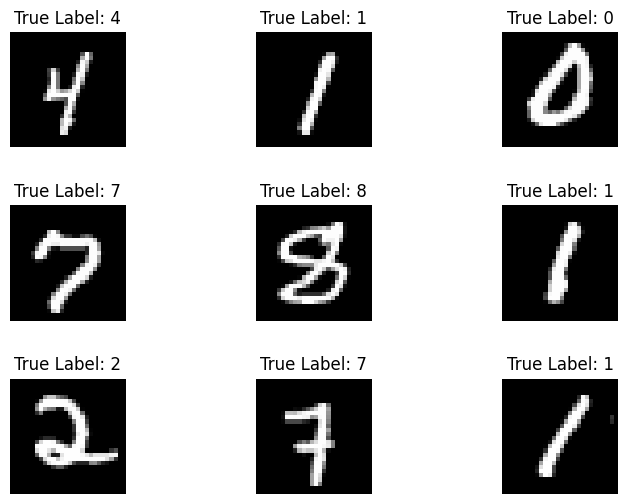

In [6]:
x_viz, y_viz = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
x_viz = tf.squeeze(x_viz, axis=3)

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')
    plt.title(f"True Label: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5)


还要检查训练数据中数字的分布，以验证每个类均在数据集中得到合理表示。


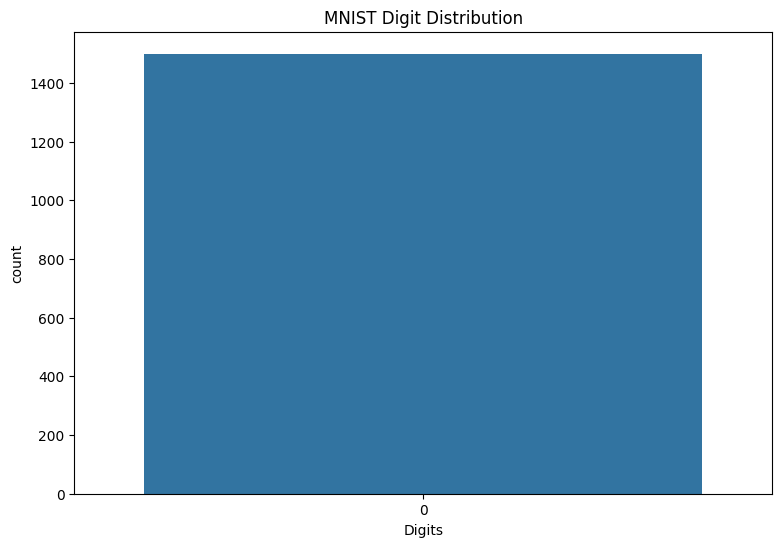

In [7]:
sns.countplot(y_viz.numpy());
plt.xlabel('Digits')
plt.title("MNIST Digit Distribution");

## 预处理数据

首先，通过展平图像将特征矩阵重塑为二维。接下来，重新缩放数据，使 [0,255] 区间内的像素值拟合至 [0,1] 区间内。此步骤可确保输入像素具有相似的分布并有助于训练收敛。

In [8]:
def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

## 构建 MLP

首先，呈现 [ReLU](https://developers.google.com/machine-learning/glossary#ReLU) 和 [Softmax](https://developers.google.com/machine-learning/glossary#softmax) 激活函数。这两个函数分别在 `tf.nn.relu` 和 `tf.nn.softmax` 中提供。ReLU 是一个非线性激活函数，会在输入值为正的情况下输出输入值，否则输出 0：

$$\text{ReLU}(X) = max(0, X)$$

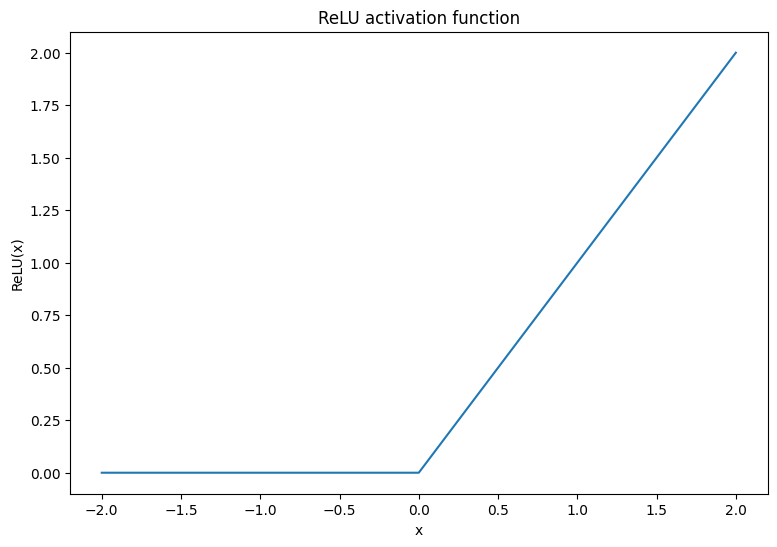

In [9]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.relu(x));
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU activation function');

softmax 激活函数是一个归一化指数函数，可以将 $m$ 个实数转换为具有 $m$ 个结果/类的概率分布。这在从神经网络的输出预测类概率方面非常实用：

$$\text{Softmax}(X) = \frac{e^{X}}{\sum_{i=1}^{m}e^{X_i}}$$

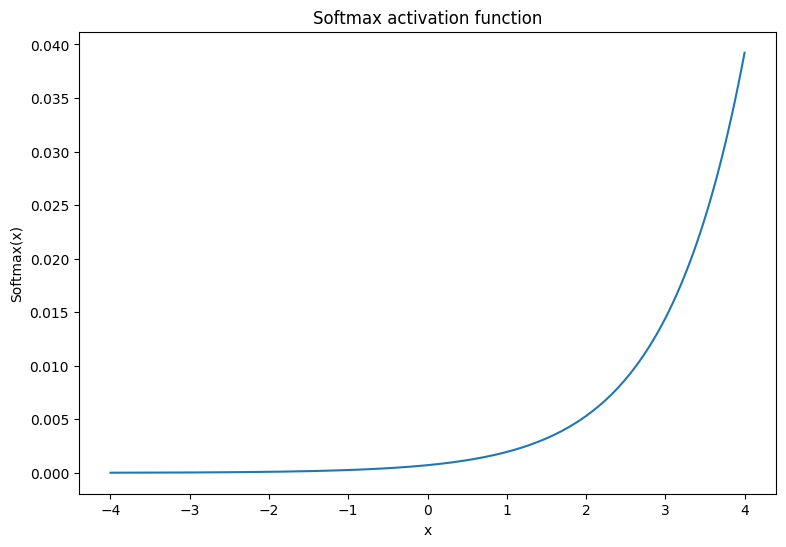

In [10]:
x = tf.linspace(-4, 4, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.softmax(x, axis=0));
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.title('Softmax activation function');

### 密集层

为密集层创建一个类。根据定义，在 MLP 中，一层的输出将完全连接到下一层的输入。因此，密集层的输入维度可以根据其前一层的输出维度进行推断，并且不需要在其初始化期间预先指定。权重也应正确初始化，以防止激活输出变得过大或过小。最热门的权重初始化方法之一是 Xavier 方案，其中权重矩阵的每个元素都以下列方式进行采样：

$$W_{ij} \sim \text{Uniform}(-\frac{\sqrt{6}}{\sqrt{n + m}},\frac{\sqrt{6}}{\sqrt{n + m}})$$

偏差向量可初始化为零。

In [11]:
def xavier_init(shape):
  # Computes the xavier initialization values for a weight matrix
  in_dim, out_dim = shape
  xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
  weight_vals = tf.random.uniform(shape=(in_dim, out_dim), 
                                  minval=-xavier_lim, maxval=xavier_lim, seed=22)
  return weight_vals

Xavier 初始化方法也可以采用 `tf.keras.initializers.GlorotUniform` 实现。

In [12]:
class DenseLayer(tf.Module):

  def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
    # Initialize the dimensions and activation functions
    self.out_dim = out_dim
    self.weight_init = weight_init
    self.activation = activation
    self.built = False

  def __call__(self, x):
    if not self.built:
      # Infer the input dimension based on first call
      self.in_dim = x.shape[1]
      # Initialize the weights and biases using Xavier scheme
      self.w = tf.Variable(xavier_init(shape=(self.in_dim, self.out_dim)))
      self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
      self.built = True
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

接下来，为按顺序执行层的 MLP 模型构建一个类。请谨记，由于维度推断，模型变量只有在第一个密集层调用序列之后才可用。

In [13]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers
   
  @tf.function
  def __call__(self, x, preds=False): 
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

初始化具有以下架构的 MLP 模型：

- 前向传递：ReLU(784 x 700) x ReLU(700 x 500) x Softmax(500 x 10)

softmax 激活函数不需要由 MLP 应用。它会在损失函数和预测函数中分别计算。

In [14]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

### 定义损失函数

交叉熵损失函数是处理多类分类问题的绝佳选择，因为它会根据模型的概率预测来衡量数据的负对数似然。分配给真实类的概率越高，损失则越低。交叉熵损失的方程如下：

$$L = -\frac{1}{n}\sum_{i=1}^{n}\sum_{i=j}^{n} {y_j}^{[i]}⋅\log(\hat{{y_j}}^{[i]})$$

其中

- $\underset{n\times m}{\hat{y}}$：预测类分布的矩阵
- $\underset{n\times m}{y}$：真实类的独热编码矩阵

`tf.nn.sparse_softmax_cross_entropy_with_logits` 函数可用于计算交叉熵损失。此函数不需要模型的最后一层应用 softmax 激活函数，也不需要对类标签进行独热编码

In [15]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

编写一个基本的准确率函数，计算训练期间正确分类的比例。为了从 softmax 输出生成类预测，返回与最大类概率相对应的索引。 

In [16]:
def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

### 训练模型

与标准梯度下降相比，使用优化器可以显著加快收敛速度。Adam 优化器实现方式如下。请参阅[优化器](https://tensorflow.google.cn/guide/core/optimizers_core)指南，以详细了解如何使用 TensorFlow Core 设计自定义优化器。

In [17]:
class Adam:

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False
      
    def apply_gradients(self, grads, vars):
      # Initialize variables on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return 

现在，编写一个自定义训练循环以使用小批量梯度下降来更新 MLP 参数。使用小批量进行训练既可以提高内存效率，又可以加快收敛速度。

In [18]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Update the model state given a batch of data
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  grads = tape.gradient(batch_loss, model.variables)
  optimizer.apply_gradients(grads, model.variables)
  return batch_loss, batch_acc

def val_step(x_batch, y_batch, loss, acc, model):
  # Evaluate the model on given a batch of validation data
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc

In [19]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Initialize data structures
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Format training loop and begin training
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_data:
      # Compute gradients and update the model's parameters
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # Keep track of batch-level training performance
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Iterate over the validation data
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

将 MLP 模型以 128 的批次大小训练 10 个周期。GPU 或 TPU 等硬件加速器也有助于加快训练速度。 

In [20]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Epoch: 0
Training loss: 0.223, Training accuracy: 0.934
Validation loss: 0.121, Validation accuracy: 0.962


Epoch: 1
Training loss: 0.080, Training accuracy: 0.975
Validation loss: 0.097, Validation accuracy: 0.971


Epoch: 2
Training loss: 0.047, Training accuracy: 0.986
Validation loss: 0.085, Validation accuracy: 0.977


Epoch: 3
Training loss: 0.033, Training accuracy: 0.990
Validation loss: 0.111, Validation accuracy: 0.971


Epoch: 4
Training loss: 0.027, Training accuracy: 0.991
Validation loss: 0.095, Validation accuracy: 0.976


Epoch: 5
Training loss: 0.022, Training accuracy: 0.992
Validation loss: 0.099, Validation accuracy: 0.976


Epoch: 6
Training loss: 0.017, Training accuracy: 0.994
Validation loss: 0.108, Validation accuracy: 0.975


Epoch: 7
Training loss: 0.018, Training accuracy: 0.994
Validation loss: 0.104, Validation accuracy: 0.976


Epoch: 8
Training loss: 0.016, Training accuracy: 0.995
Validation loss: 0.104, Validation accuracy: 0.979


Epoch: 9
Training loss: 0.014, Training accuracy: 0.995
Validation loss: 0.116, Validation accuracy: 0.976


### 性能评估

首先，编写一个绘图函数来呈现模型在训练期间的损失和准确率。 

In [21]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(val_metric)), val_metric, label = f"Validation {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training epochs");

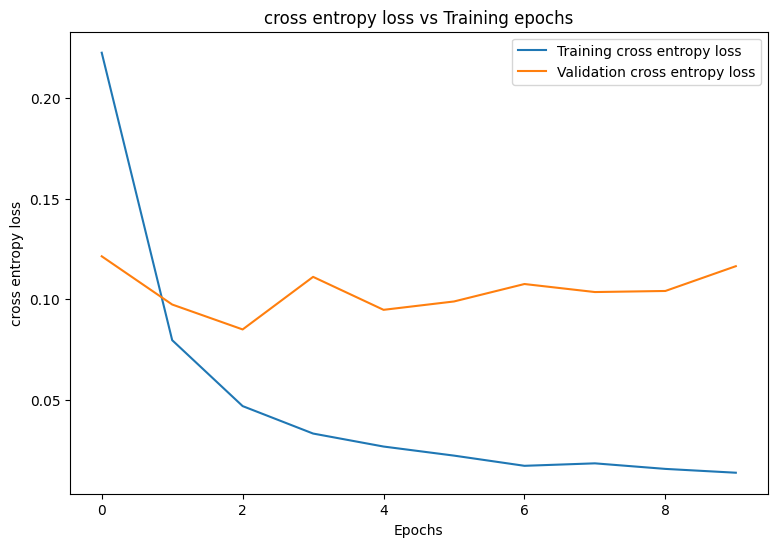

In [22]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

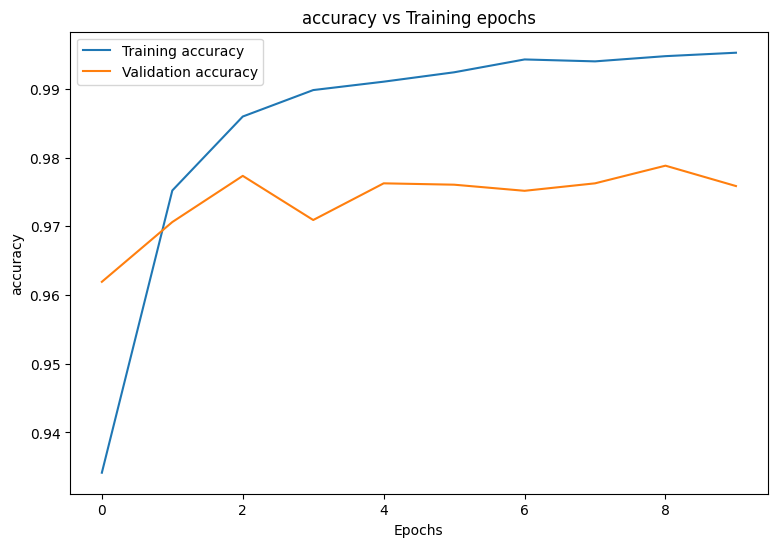

In [23]:
plot_metrics(train_accs, val_accs, "accuracy")

## 保存和加载模型

首先，构建一个接受原始数据并执行以下运算的导出模块：

- 数据预处理
- 概率预测
- 类预测

In [24]:
class ExportModule(tf.Module):
  def __init__(self, model, preprocess, class_pred):
    # Initialize pre and postprocessing functions
    self.model = model
    self.preprocess = preprocess
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, None, None], dtype=tf.uint8)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.preprocess(x)
    y = self.model(x)
    y = self.class_pred(y)
    return y 

In [25]:
def preprocess_test(x):
  # The export module takes in unprocessed and unlabeled data
  x = tf.reshape(x, shape=[-1, 784])
  x = x/255
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return tf.argmax(tf.nn.softmax(y), axis=1)

现在，可以使用 `tf.saved_model.save` 函数保存此导出模块。 

In [26]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

In [27]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp33olpz31/mlp_model_export/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp33olpz31/mlp_model_export/assets


使用 `tf.saved_model.load` 加载保存的模型，并检查其在未知测试数据上的性能。

In [28]:
mlp_loaded = tf.saved_model.load(save_path)

In [29]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.977


该模型在对训练数据集中的手写数字进行分类方面表现十分优秀，而且有效地泛化到了未知数据。现在，检查模型的分类准确率，以确保对每个数字都具有出色的性能。 

In [30]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  label_filled = tf.cast(tf.fill(pred_label.shape[0], label), tf.int64)
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, label_filled).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 7: 0.955
Digit 4: 0.958
Digit 8: 0.962
Digit 6: 0.970
Digit 5: 0.980
Digit 9: 0.983
Digit 3: 0.984
Digit 2: 0.988
Digit 0: 0.993
Digit 1: 0.996


该模型在对某些数字进行分类时的性能似乎稍逊于其他数字，这种情况在许多多类分类问题中都十分常见。作为最后的练习，请绘制出模型预测的混淆矩阵及其对应的真实标签，以便在类级别收集更多见解。Sklearn 和 Seaborn 中具有生成和可视化混淆矩阵的函数。 

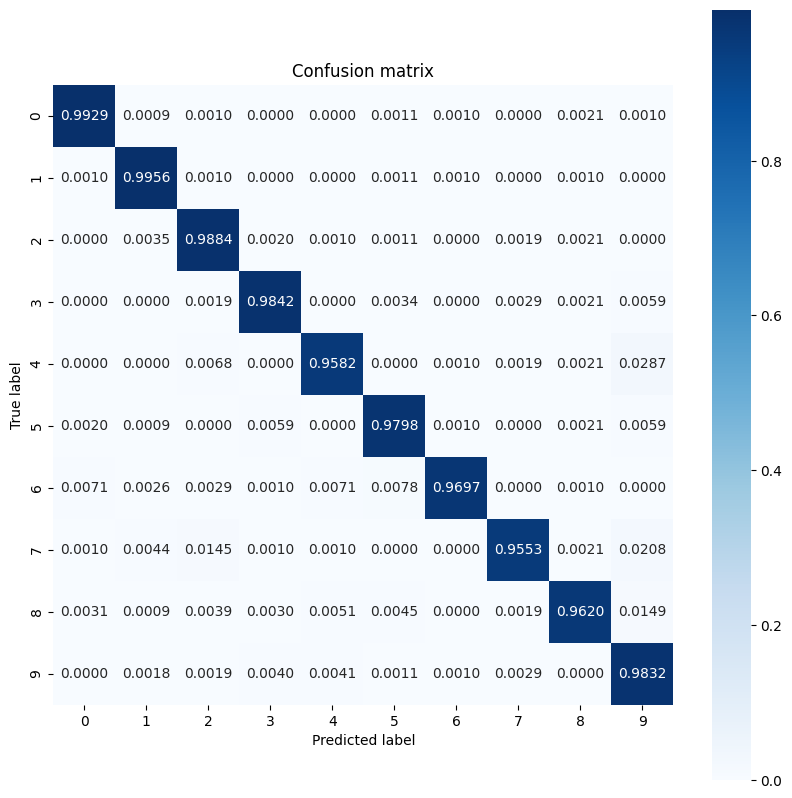

In [31]:
import sklearn.metrics as sk_metrics

def show_confusion_matrix(test_labels, test_classes):
  # Compute confusion matrix and normalize
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(test_labels.numpy(), 
                                          test_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1)
  axis_labels = range(10)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(y_test, test_classes)

在类级别获得更多见解有助于确定错误分类的原因并在未来的训练周期中提高模型性能。

## 结论

此笔记本介绍了使用 [MLP](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax) 处理多类分类问题的几种技术。下面是一些可能有所帮助的提示：

- [TensorFlow Core API](https://tensorflow.google.cn/guide/core) 可用于构建具有高度可配置性的机器学习工作流
- 初始化方案有助于防止模型参数在训练期间消失或爆炸。
- 过拟合是神经网络的另一个常见问题，但本教程不存在此问题。有关这方面的更多帮助，请参阅[过拟合与欠拟合](overfit_and_underfit.ipynb)教程。

有关使用 TensorFlow Core API 的更多示例，请查阅[指南](https://tensorflow.google.cn/guide/core)。如果您想详细了解如何加载和准备数据，请参阅有关[图像数据加载](https://tensorflow.google.cn/tutorials/load_data/images)或 [CSV 数据加载](https://tensorflow.google.cn/tutorials/load_data/csv)的教程。